
# Transformer代码实现

参考：

[Attention Is All You Need](https://arxiv.org/pdf/1706.03762.pdf)

[The Illustrated Transformer](http://jalammar.github.io/illustrated-transformer)

[PyTorch官方教程：Sequence-to-Sequence Modeling with nn.Transformer and TorchText](https://pytorch.org/tutorials/beginner/transformer_tutorial.html)

[TF官方教程：理解语言的 Transformer 模型](https://tensorflow.google.cn/tutorials/text/transformer)

## 目录

1. 数据预处理

2. Transformer模型概况

3. 位置编码（positional encoding）

4. 编码器（encoder）

    * 自注意力机制（self attention）

    * 层归一化（layer normalization）、残差连接
    
    * 前馈网络（feed forward）

    * 编码器整体结构
    
5. 解码器（decoder）

6. 注意力掩码机制

7. Transformer模型

8. 模型训练

9. 模型预测

In [1]:
import copy
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import time
import torch
import torch.nn as nn
import torch.nn.functional as F

from collections import Counter
from langconv import Converter
from nltk import word_tokenize
from torch.autograd import Variable

%matplotlib inline

In [2]:
# 初始化参数设置
PAD = 0                             # padding占位符的索引
UNK = 1                             # 未登录词标识符的索引
BATCH_SIZE = 128                    # 批次大小
EPOCHS = 20                         # 训练轮数
LAYERS = 6                          # transformer中encoder、decoder层数
H_NUM = 8                           # 多头注意力个数
D_MODEL = 256                       # 输入、输出词向量维数
D_FF = 1024                         # feed forward全连接层维数
DROPOUT = 0.1                       # dropout比例
MAX_LENGTH = 60                     # 语句最大长度

TRAIN_FILE = 'nmt/en-cn/train.txt'  # 训练集
DEV_FILE = "nmt/en-cn/dev.txt"      # 验证集
SAVE_FILE = 'save/model.pt'         # 模型保存路径
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1. 数据预处理

注意：使用中文语料训练Transformer模型时，中文语句一般**以字为单位进行切分**，即无需对中文语句分词。

注意：**同一批次中seq_len相同，不同批次间seq_len可能变化。**

In [3]:
def seq_padding(X, padding=PAD):
    """
    按批次（batch）对数据填充、长度对齐
    """
    # 计算该批次各条样本语句长度
    L = [len(x) for x in X]
    # 获取该批次样本中语句长度最大值
    ML = max(L)
    # 遍历该批次样本，如果语句长度小于最大长度，则用padding填充
    return np.array([
        np.concatenate([x, [padding] * (ML - len(x))]) if len(x) < ML else x for x in X
    ])

def cht_to_chs(sent):
    sent = Converter("zh-hans").convert(sent)
    sent.encode("utf-8")
    return sent

In [4]:
class PrepareData:
    def __init__(self, train_file, dev_file):
        # 读取数据、分词
        self.train_en, self.train_cn = self.load_data(train_file)
        self.dev_en, self.dev_cn = self.load_data(dev_file)
        # 构建词表
        self.en_word_dict, self.en_total_words, self.en_index_dict = \
            self.build_dict(self.train_en)
        self.cn_word_dict, self.cn_total_words, self.cn_index_dict = \
            self.build_dict(self.train_cn)
        # 单词映射为索引
        self.train_en, self.train_cn = self.word2id(self.train_en, self.train_cn, self.en_word_dict, self.cn_word_dict)
        self.dev_en, self.dev_cn = self.word2id(self.dev_en, self.dev_cn, self.en_word_dict, self.cn_word_dict)
        # 划分批次、填充、掩码
        self.train_data = self.split_batch(self.train_en, self.train_cn, BATCH_SIZE)
        self.dev_data = self.split_batch(self.dev_en, self.dev_cn, BATCH_SIZE)

    def load_data(self, path):
        """
        读取英文、中文数据
        对每条样本分词并构建包含起始符和终止符的单词列表
        形式如：en = [['BOS', 'i', 'love', 'you', 'EOS'], ['BOS', 'me', 'too', 'EOS'], ...]
                cn = [['BOS', '我', '爱', '你', 'EOS'], ['BOS', '我', '也', '是', 'EOS'], ...]
        """
        en = []
        cn = []
        with open(path, mode="r", encoding="utf-8") as f:
            for line in f.readlines():
                sent_en, sent_cn = line.strip().split("\t")
                sent_en = sent_en.lower()
                sent_cn = cht_to_chs(sent_cn)
                sent_en = ["BOS"] + word_tokenize(sent_en) + ["EOS"]
                # 中文按字符切分
                sent_cn = ["BOS"] + [char for char in sent_cn] + ["EOS"]
                en.append(sent_en)
                cn.append(sent_cn)
        return en, cn
    
    def build_dict(self, sentences, max_words=5e4):
        """
        构造分词后的列表数据
        构建单词-索引映射（key为单词，value为id值）
        """
        # 统计数据集中单词词频
        word_count = Counter([word for sent in sentences for word in sent])
        # 按词频保留前max_words个单词构建词典
        # 添加UNK和PAD两个单词
        ls = word_count.most_common(int(max_words))
        total_words = len(ls) + 2
        word_dict = {w[0]: index + 2 for index, w in enumerate(ls)}
        word_dict['UNK'] = UNK
        word_dict['PAD'] = PAD
        # 构建id2word映射
        index_dict = {v: k for k, v in word_dict.items()}
        return word_dict, total_words, index_dict

    def word2id(self, en, cn, en_dict, cn_dict, sort=True):
        """
        将英文、中文单词列表转为单词索引列表
        `sort=True`表示以英文语句长度排序，以便按批次填充时，同批次语句填充尽量少
        """
        length = len(en)
        # 单词映射为索引
        out_en_ids = [[en_dict.get(word, UNK) for word in sent] for sent in en]
        out_cn_ids = [[cn_dict.get(word, UNK) for word in sent] for sent in cn]
        # 按照语句长度排序
        def len_argsort(seq):
            """
            传入一系列语句数据(分好词的列表形式)，
            按照语句长度排序后，返回排序后原来各语句在数据中的索引下标
            """
            return sorted(range(len(seq)), key=lambda x: len(seq[x]))
        # 按相同顺序对中文、英文样本排序
        if sort:
            # 以英文语句长度排序
            sorted_index = len_argsort(out_en_ids)
            out_en_ids = [out_en_ids[idx] for idx in sorted_index]
            out_cn_ids = [out_cn_ids[idx] for idx in sorted_index]
        return out_en_ids, out_cn_ids

    def split_batch(self, en, cn, batch_size, shuffle=True):
        """
        划分批次
        `shuffle=True`表示对各批次顺序随机打乱
        """
        # 每隔batch_size取一个索引作为后续batch的起始索引
        idx_list = np.arange(0, len(en), batch_size)
        # 起始索引随机打乱
        if shuffle:
            np.random.shuffle(idx_list)
        # 存放所有批次的语句索引
        batch_indexs = []
        for idx in idx_list:
            """
            形如[array([4, 5, 6, 7]), 
                 array([0, 1, 2, 3]), 
                 array([8, 9, 10, 11]),
                 ...]
            """
            # 起始索引最大的批次可能发生越界，要限定其索引
            batch_indexs.append(np.arange(idx, min(idx + batch_size, len(en))))
        # 构建批次列表
        batches = []
        for batch_index in batch_indexs:
            # 按当前批次的样本索引采样
            batch_en = [en[index] for index in batch_index]
            batch_cn = [cn[index] for index in batch_index]
            # 对当前批次中所有语句填充、对齐长度
            # 维度为：batch_size * 当前批次中语句的最大长度
            batch_cn = seq_padding(batch_cn)
            batch_en = seq_padding(batch_en)
            # 将当前批次添加到批次列表
            # Batch类用于实现注意力掩码
            batches.append(Batch(batch_en, batch_cn))
        return batches

In [5]:
# 示例
# data_mini = PrepareData("./nmt/en-cn/train_mini.txt", "./nmt/en-cn/dev_mini.txt")
# print("*** batch 0, en ***")
# print(data_mini.train_data[0][0])
# print("*** batch 0, chs ***")
# print(data_mini.train_data[0][1])
# print("*** en word to index ***")
# print(data_mini.en_word_dict)
# print("*** chs word to index ***")
# print(data_mini.cn_word_dict)


## 2. Transformer模型概况
  
**Transformer**和**LSTM**的最大区别：LSTM采用迭代（自回归）训练方式，而Transformer可以并行训练，极大加快计算效率。Transformer使用位置编码（positional encoding）理解语言的顺序，使用自注意力机制和全连接层前向计算。   
  
Transformer模型由**编码器**和**解码器**组成，

* **编码器（encoder）**

将自然语言序列映射成为**隐藏层表示**（下图中九宫格），即自然语言序列的数学表达

* **解码器（decoder）**

将隐藏层表示映射为自然语言序列，进而解决各种任务，如情感分类、命名实体识别、语义关系抽取、摘要生成、机器翻译等。

![](./img/transformer.jpg)

![](./img/intuition.jpg)

* **词向量（embedding）**  
  
使用可学习的词向量表（input & output embeddings）将输入、输出索引映射为$d_{model}$-维词向量。词向量表可随机初始化，也可加载预训练词向量，如word2vec、glove等。


In [6]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        # Embedding层
        self.lut = nn.Embedding(vocab, d_model)
        # Embedding维数
        self.d_model = d_model

    def forward(self, x):
        # 返回x的词向量（需要乘以math.sqrt(d_model)）
        return self.lut(x) * math.sqrt(self.d_model)

## 3. 位置编码

由于训练Transformer模型时，序列输入采用并行方式，因此缺少单词的位置信息，通过在Transformer的输入中加入单词位置编码信息，使Transformer能够识别语句中单词的位置关系。   
  
**位置编码（positional encoding）**：位置编码向量与词向量维度相同，$\text{max_seq_len} \times \text{embedding_dim}$。   

  
Transformer原文中使用正、余弦函数的线性变换对单词位置编码：   
  
$$\text{PE}_{pos, 2i} = \sin \left( \frac{pos}{10000^{2i / d_{\text{model}}}} \right) \\ 
\text{PE}_{(pos,2i + 1)} = \cos \left( \frac{pos}{10000^{2i / d_{\text{model}}}} \right)\tag{eq.1}$$  
  
其中，$pos \in [0, \text{max_seq_len})$表示单词在语句中的位置，$i \in [0, \text{embedding_dim})$表示词向量维度。位置编码函数的波长在$[2 \pi, 10000 \times 2 \pi]$区间内变化，语句中每一个单词位置沿词向量维度由周期不同的正、余弦函数交替取值组合，生成独一纹理信息，从而使模型学到位置间的依赖关系和自然语言的时序特性。   

In [7]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        # 位置编码矩阵，维度[max_len, embedding_dim]
        pe = torch.zeros(max_len, d_model, device=DEVICE)
        # 单词位置
        position = torch.arange(0.0, max_len, device=DEVICE)
        position.unsqueeze_(1)
        # 使用exp和log实现幂运算
        div_term = torch.exp(torch.arange(0.0, d_model, 2, device=DEVICE) * (- math.log(1e4) / d_model))
        div_term.unsqueeze_(0)
        # 计算单词位置沿词向量维度的纹理值
        pe[:, 0 : : 2] = torch.sin(torch.mm(position, div_term))
        pe[:, 1 : : 2] = torch.cos(torch.mm(position, div_term))
        # 增加批次维度，[1, max_len, embedding_dim]
        pe.unsqueeze_(0)
        # 将位置编码矩阵注册为buffer(不参加训练)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # 将一个批次中语句所有词向量与位置编码相加
        # 注意，位置编码不参与训练，因此设置requires_grad=False
        x += Variable(self.pe[:, : x.size(1), :], requires_grad=False)
        return self.dropout(x)

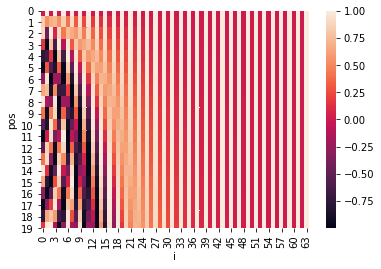

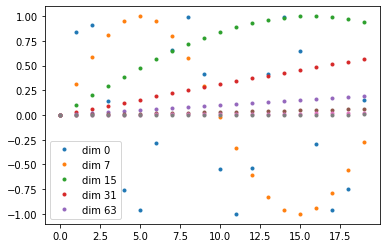

In [8]:
emb_dim = 64
max_seq_len = 100
seq_len = 20

pe = PositionalEncoding(emb_dim, 0, max_seq_len)
positional_encoding = pe(torch.zeros(1, seq_len, emb_dim, device=DEVICE))
plt.figure()
sns.heatmap(positional_encoding.squeeze().to("cpu"))
plt.xlabel("i")
plt.ylabel("pos")
plt.show()

plt.figure()
y = positional_encoding.to("cpu").numpy()
plt.plot(np.arange(seq_len), y[0, :, 0 : 64 : 8], ".")
plt.legend(["dim %d" % p for p in [0, 7, 15, 31, 63]])
plt.show()

## 4. 编码器
  
Transformer的编码器能够独立完成一些主流自然语言处理任务, 如情感分类、语义关系分析、命名实体识别等。Transformer编码器单元结构：

![](./img/encoder.jpg)

### 4.1 自注意力机制

![](./img/attention_0.jpg)

![](./img/attention_1.jpg)

![](./img/attention_2.jpg)

* **$\sqrt{d_{k}}$归一化**  
  
假设$\mathbf{q}$、$\mathbf{k}$为均值0、方差1的独立随机变量，其点积注意力$\mathbf{q} \cdot \mathbf{k} = \sum_{i=1}^{d_k}{\mathbf{q}_{i} \mathbf{k}_{i}}$的均值和方差分别为0、$d_{k}$。通过$\sqrt{d_{k}}$缩放，使softmax结果更稳定（防止单词-单词间的点积注意力差异太大），便于反向传播时梯度平衡。


In [9]:
def clones(module, N):
    """
    克隆基本单元，克隆的单元之间参数不共享
    """
    return nn.ModuleList([
        copy.deepcopy(module) for _ in range(N)
    ])

In [10]:
def attention(query, key, value, mask=None, dropout=None):
    """
    Scaled Dot-Product Attention（方程（4））
    """
    # q、k、v向量长度为d_k
    d_k = query.size(-1)
    # 矩阵乘法实现q、k点积注意力，sqrt(d_k)归一化
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    # 注意力掩码机制
    if mask is not None:
        scores = scores.masked_fill(mask==0, -1e9)
    # 注意力矩阵softmax归一化
    p_attn = F.softmax(scores, dim=-1)
    # dropout
    if dropout is not None:
        p_attn = dropout(p_attn)
    # 注意力对v加权
    return torch.matmul(p_attn, value), p_attn

In [11]:
class MultiHeadedAttention(nn.Module):
    """
    Multi-Head Attention（编码器（2））
    """
    def __init__(self, h, d_model, dropout=0.1):
        super(MultiHeadedAttention, self).__init__()
        """
        `h`：注意力头的数量
        `d_model`：词向量维数
        """
        # 确保整除
        assert d_model % h == 0
        # q、k、v向量维数
        self.d_k = d_model // h
        # 头的数量
        self.h = h
        # WQ、WK、WV矩阵及多头注意力拼接变换矩阵WO
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        if mask is not None:
            mask = mask.unsqueeze(1)
        # 批次大小
        nbatches = query.size(0)
        # WQ、WK、WV分别对词向量线性变换，并将结果拆成h块
        query, key, value = [
            l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
            for l, x in zip(self.linears, (query, key, value))
        ]
        # 注意力加权
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)
        # 多头注意力加权拼接
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)
        # 对多头注意力加权拼接结果线性变换
        return self.linears[-1](x)

### 4.2 层归一化、残差连接

* **层归一化**

层归一化将神经网络中隐藏层归一化为标准正态分布，以加快训练速度

![](./img/layer_norm.jpg)

$$\begin{aligned}
\mu^{l} & = \frac{1}{H} \sum_{i = 1}^{H} x_{i}^{l} \\  
\sigma^{l} & = \sqrt{\frac{1}{H} \sum_{i = 1}^{H} (x_{i}^{l} - \mu^{l})^{2}} \\
\text{LayerNorm}(\mathbf{x}^{l}) & = \alpha \odot \frac{\mathbf{x}^{l} - \mu^{l}}{\sqrt{(\sigma^{l})^{2} + \epsilon}} + \beta
\end{aligned} \tag{5}$$

其中，$\odot$表示Hadamard积，即两个向量对应元素相乘。$\alpha$、$\beta$为可训练参数，以弥补归一化过程损失信息。通常$\alpha$、$\beta$分别初始化为1、0。  

In [12]:
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        # α、β分别初始化为1、0
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        # 平滑项
        self.eps = eps

    def forward(self, x):
        # 沿词向量方向计算均值和方差
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True)
        # 沿词向量和语句序列方向计算均值和方差
        # mean = x.mean(dim=[-2, -1], keepdim=True)
        # std = x.std(dim=[-2, -1], keepdim=True)
        # 归一化
        x = (x - mean) / torch.sqrt(std ** 2 + self.eps)
        return self.a_2 * x + self.b_2

* **残差连接**
  
残差连接：训练时，梯度通过捷径直接反向传播至前层

$$\mathbf{x} + \text{SubLayer}(\mathbf{x}) \tag{6}$$

其中，$\text{SubLayer}$表示`Add & Norm`前层模块，如`Multi-Head Attention`、`Feed Forward`。

In [13]:
class SublayerConnection(nn.Module):
    """
    通过层归一化和残差连接，连接Multi-Head Attention和Feed Forward
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        # 层归一化
        x_ = self.norm(x)
        x_ = sublayer(x_)
        x_ = self.dropout(x_)
        # 残差连接
        return x + x_

### 4.3 前馈网络

前馈网络（Feed Forward）为两层线性映射及激活函数

In [14]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.w_1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.w_2(x)
        return x

### 4.4 Transformer编码器整体结构

Transformer编码器基本单元由两个子层组成：第一个子层实现多头**自注意力（self-attention）**机制（Multi-Head Attention）；第二个子层实现全连接前馈网络。计算过程如下：
  
1. **词向量与位置编码**

$$X = \text{EmbeddingLookup}(X) + \text{PositionalEncoding} \tag{2}$$

$$X \in \mathbb{R}^{\text{batch_size} \times \text{seq_len} \times \text{embedding_dim}}$$

2. **自注意力机制**

$$Q = \text{Linear}(X) = X W_{Q}$$

$$K = \text{Linear}(X) = XW_{K} \tag{3}$$

$$V = \text{Linear}(X) = XW_{V}$$

$$X_{\text{attention}} = \text{SelfAttention}(Q, K, V) \tag{4}$$

3. **层归一化、残差连接**

$$X_{\text{attention}} = \text{LayerNorm}(X_{\text{attention}}) \tag{5}$$

$$X_{\text{attention}} = X + X_{\text{attention}} \tag{6}$$  

4. **前馈网络**

$$X_{\text{hidden}} = \text{Linear}(\text{Activate}(\text{Linear}(X_{\text{attention}}))) \tag{7}$$

5. **层归一化、残差连接**

$$X_{\text{hidden}} = \text{LayerNorm}(X_{\text{hidden}})$$

$$X_{\text{hidden}} = X_{\text{attention}} + X_{\text{hidden}}$$

$$X_{\text{hidden}} \in \mathbb{R}^{\text{batch_size} \times \text{seq_len} \times \text{embedding_dim}}$$

Transformer编码器由$N = 6$个编码器基本单元组成。

In [15]:
class EncoderLayer(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        # SublayerConnection作用连接multi和ffn
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        # d_model
        self.size = size

    def forward(self, x, mask):
        # 将embedding层进行Multi head Attention
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        # attn的结果直接作为下一层输入
        return self.sublayer[1](x, self.feed_forward)

In [16]:
class Encoder(nn.Module):
    def __init__(self, layer, N):
        """
        layer = EncoderLayer
        """
        super(Encoder, self).__init__()
        # 复制N个编码器基本单元
        self.layers = clones(layer, N)
        # 层归一化
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        """
        循环编码器基本单元N次
        """
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

## 5. 解码器

![](./img/decoder.jpg)

解码器同样由$N$层解码器基本单元堆叠而成，与编码器基本单元不同的是：在编码器基本单元的多头**自注意力**机制及前馈网络之间插入一个**上下文注意力（context-attention）**机制（Multi-Head Attention）层，用解码器基本单元的自注意力机制输出作为$q$查询编码器的输出，以便解码时，解码器获得编码器的所有输出，即上下文注意力机制的$K$、$V$来自编码器的输出，$Q$来自解码器前一时刻的输出。

编码器和解码器注意力的区别：

![](./img/attention.png)

解码器基本单元的输入、输出：

* 输入：编码器的输出、解码器前一时刻的输出

* 输出：对应当前时刻输出单词的概率分布

此外，解码器的输出（最后一个解码器基本单元的输出）需要经线性变换和softmax函数映射为下一时刻预测单词的概率分布。  

解码器**解码过程**：给定编码器输出（编码器输入语句所有单词的词向量）和解码器前一时刻输出（单词），预测当前时刻单词的概率分布。

注意：训练过程中，编、解码器均可以并行计算（训练语料中已知前一时刻单词）；推理过程中，编码器可以并行计算，解码器需要像RNN一样依次预测输出单词。


In [17]:
class Decoder(nn.Module):
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        """
        循环解码器基本单元N次
        """
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

In [18]:
class DecoderLayer(nn.Module):
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        # 自注意力机制
        self.self_attn = self_attn
        # 上下文注意力机制
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)

    def forward(self, x, memory, src_mask, tgt_mask):
        # memory为编码器输出隐表示
        m = memory
        # 自注意力机制，q、k、v均来自解码器隐表示
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        # 上下文注意力机制：q为来自解码器隐表示，而k、v为编码器隐表示
        x = self.sublayer[1](x, lambda x: self.self_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

In [19]:
class Generator(nn.Module):
    """
    解码器输出经线性变换和softmax函数映射为下一时刻预测单词的概率分布
    """
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        # decode后的结果，先进入一个全连接层变为词典大小的向量
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        # 然后再进行log_softmax操作(在softmax结果上再做多一次log运算)
        return F.log_softmax(self.proj(x), dim=-1)

## 6. 注意力掩码机制

### 6.1 编码器注意力掩码

编码器注意力掩码的目地：使批次中较短语句的填充部分不参与注意力计算。
  
![](./img/attention_mask2.jpg)

模型训练通常按批次进行，同一批次中的语句长度可能不同，因此需要按语句最大长度对短语句进行0填充以补齐长度。语句填充部分属于无效信息，不应参与前向传播，考虑softmax函数特性，

$$\text{softmax}(\mathbf {z})_{i} = {\frac{\exp(z_{i})}{\sum _{j = 1}^{K} \exp(z_{j})}}$$

当$z_{i}$为填充时，可令$z_{i} = - \infty$（一般取很大的负数）使其无效。

$$z_{\text{pad}} = - \infty, \exp(z_{\text{pad}}) = 0$$

![](./img/attention_mask.jpg)

编码器注意力掩码生成伪代码：

```python
# True表示有效；False表示无效（填充位）
mask = src != pad
# 将无效位置为负无穷
scores = scores.masked_fill(~mask, -1e9)
```

### 6.2 解码器注意力掩码


解码器注意力掩码相对于编码器略微复杂，不仅需要将填充部分屏蔽掉，还需要对当前及后续序列进行屏蔽（`subsequent_mask`），即解码器在预测当前时刻单词时，不能知道当前及后续单词内容，因此注意力掩码需要将当前时刻之后的注意力分数全部置为$- \infty$，然后再计算$softmax$，防止发生数据泄露。

subsequent_mask的矩阵形式为一个下三角矩阵，在主对角线右上位置全部为False

![](./img/subsequent_mask.png)


In [20]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    # 设定subsequent_mask矩阵的shape
    attn_shape = (1, size, size)
    # 生成一个右上角(不含主对角线)为全1，左下角(含主对角线)为全0的subsequent_mask矩阵
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    # 返回一个右上角(不含主对角线)为全False，左下角(含主对角线)为全True的subsequent_mask矩阵
    return torch.from_numpy(subsequent_mask) == 0

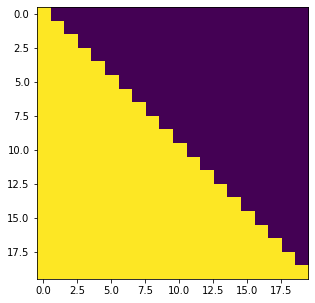

In [21]:
plt.figure(figsize=(5, 5))
plt.imshow(subsequent_mask(20)[0])
plt.show()

In [22]:
class Batch:
    """
    批次类
        1. 输入序列（源）
        2. 输出序列（目标）
        3. 构造掩码
    """
    def __init__(self, src, trg=None, pad=PAD):
        # 将输入、输出单词id表示的数据规范成整数类型
        src = torch.from_numpy(src).to(DEVICE).long()
        trg = torch.from_numpy(trg).to(DEVICE).long()
        self.src = src
        # 对于当前输入的语句非空部分进行判断，bool序列
        # 并在seq length前面增加一维，形成维度为 1×seq length 的矩阵
        self.src_mask = (src != pad).unsqueeze(-2)
        # 如果输出目标不为空，则需要对解码器使用的目标语句进行掩码
        if trg is not None:
            # 解码器使用的目标输入部分
            self.trg = trg[:, : -1]
            # 解码器训练时应预测输出的目标结果
            self.trg_y = trg[:, 1 :]
            # 将目标输入部分进行注意力掩码
            self.trg_mask = self.make_std_mask(self.trg, pad)
            # 将应输出的目标结果中实际的词数进行统计
            self.ntokens = (self.trg_y != pad).data.sum()
    
    # 掩码操作
    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask

## 7. Transformer模型


In [23]:
class Transformer(nn.Module):
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(Transformer, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator

    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)

    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

    def forward(self, src, tgt, src_mask, tgt_mask):
        # encoder的结果作为decoder的memory参数传入，进行decode
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)

In [24]:
def make_model(src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h = 8, dropout=0.1):
    c = copy.deepcopy
    # 实例化Attention对象
    attn = MultiHeadedAttention(h, d_model).to(DEVICE)
    # 实例化FeedForward对象
    ff = PositionwiseFeedForward(d_model, d_ff, dropout).to(DEVICE)
    # 实例化PositionalEncoding对象
    position = PositionalEncoding(d_model, dropout).to(DEVICE)
    # 实例化Transformer模型对象
    model = Transformer(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout).to(DEVICE), N).to(DEVICE),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout).to(DEVICE), N).to(DEVICE),
        nn.Sequential(Embeddings(d_model, src_vocab).to(DEVICE), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab).to(DEVICE), c(position)),
        Generator(d_model, tgt_vocab)).to(DEVICE)
    
    # This was important from their code. 
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            # 这里初始化采用的是nn.init.xavier_uniform
            nn.init.xavier_uniform_(p)
    return model.to(DEVICE)

## 8. 模型训练

**标签平滑**

训练过程中，采用KL散度损失实现标签平滑（$\epsilon_{ls} = 0.1$）策略，提高模型鲁棒性、准确性和BLEU分数。

标签平滑：输出概率分布由one-hot方式转为真实标签的概率置为`confidence`，其它所有非真实标签概率平分`1 - confidence`。

In [25]:
class LabelSmoothing(nn.Module):
    """
    标签平滑
    """
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(reduction='sum')
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))

tensor([[0.0000, 0.1333, 0.6000, 0.1333, 0.1333],
        [0.0000, 0.6000, 0.1333, 0.1333, 0.1333],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])


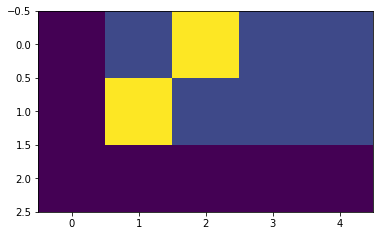

In [26]:
# Label smoothing的例子
crit = LabelSmoothing(5, 0, 0.4)  # 设定一个ϵ=0.4
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0], 
                             [0, 0.2, 0.7, 0.1, 0]])
v = crit(Variable(predict.log()), 
         Variable(torch.LongTensor([2, 1, 0])))

# Show the target distributions expected by the system.
print(crit.true_dist)
plt.imshow(crit.true_dist)

**计算损失**

In [27]:
class SimpleLossCompute:
    """
    简单的计算损失和进行参数反向传播更新训练的函数
    """
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt
        
    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), 
                              y.contiguous().view(-1)) / norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.data.item() * norm.float()

**优化器**

Adam优化器，$\beta_1=0.9、\beta_2=0.98$ 和 $\epsilon = 10^{−9}$，并使用warmup策略调整学习率：  
  
$$ lr = d_{\text{model}}^{−0.5} \min(\text{step_num}^{−0.5}, \text{step_num} \times \text{warmup_steps}^{−1.5})$$  

使用固定步数$\text{warmup_steps}$**先使学习率的线性增长（热身）**，而后随着$\text{step_num}$的增加以$\text{step_num}$的反平方根成比例**逐渐减小学习率**。

In [28]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * (self.model_size ** (-0.5) * min(step ** (-0.5), step * self.warmup ** (-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

主要调节是在 $rate$ 这个函数中，其中
- $model\_size$ 即为 $d_{model}$
- $warmup$ 即为 $warmup\_steps$
- $factor$ 可以理解为初始的学习率

以下对该优化器在**不同模型大小（$model\_size$）**和**不同超参数（$marmup$）值**的情况下的学习率（$lrate$）曲线进行示例。 

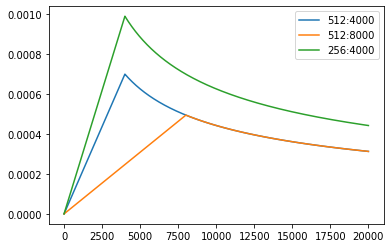

In [29]:
# Three settings of the lrate hyperparameters.
opts = [NoamOpt(512, 1, 4000, None), 
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])

**训练迭代**

接下来，我们创建一个通用的训练和评分功能来跟踪损失。 我们传入一个上面定义的损失计算函数，它也处理参数更新。

In [30]:
def run_epoch(data, model, loss_compute, epoch):
    start = time.time()
    total_tokens = 0.
    total_loss = 0.
    tokens = 0.

    for i , batch in enumerate(data):
        out = model(batch.src, batch.trg, batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens)

        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens

        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch %d Batch: %d Loss: %f Tokens per Sec: %fs" % (epoch, i - 1, loss / batch.ntokens, (tokens.float() / elapsed / 1000.)))
            start = time.time()
            tokens = 0

    return total_loss / total_tokens


def train(data, model, criterion, optimizer):
    """
    训练并保存模型
    """
    # 初始化模型在dev集上的最优Loss为一个较大值
    best_dev_loss = 1e5
    
    for epoch in range(EPOCHS):
        # 模型训练
        model.train()
        run_epoch(data.train_data, model, SimpleLossCompute(model.generator, criterion, optimizer), epoch)
        model.eval()

        # 在dev集上进行loss评估
        print('>>>>> Evaluate')
        dev_loss = run_epoch(data.dev_data, model, SimpleLossCompute(model.generator, criterion, None), epoch)
        print('<<<<< Evaluate loss: %f' % dev_loss)
        
        # 如果当前epoch的模型在dev集上的loss优于之前记录的最优loss则保存当前模型，并更新最优loss值
        if dev_loss < best_dev_loss:
            torch.save(model.state_dict(), SAVE_FILE)
            best_dev_loss = dev_loss
            print('****** Save model done... ******')       
            
        print()

In [31]:
# 数据预处理
data = PrepareData(TRAIN_FILE, DEV_FILE)
src_vocab = len(data.en_word_dict)
tgt_vocab = len(data.cn_word_dict)
print("src_vocab %d" % src_vocab)
print("tgt_vocab %d" % tgt_vocab)

# 初始化模型
model = make_model(
                    src_vocab, 
                    tgt_vocab, 
                    LAYERS, 
                    D_MODEL, 
                    D_FF,
                    H_NUM,
                    DROPOUT
                )

# 训练
print(">>>>>>> start train")
train_start = time.time()
criterion = LabelSmoothing(tgt_vocab, padding_idx = 0, smoothing= 0.0)
optimizer = NoamOpt(D_MODEL, 1, 2000, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9,0.98), eps=1e-9))

train(data, model, criterion, optimizer)
print(f"<<<<<<< finished train, cost {time.time()-train_start:.4f} seconds")

src_vocab 5493
tgt_vocab 2537
>>>>>>> start train
Epoch 0 Batch: 0 Loss: 7.958462 Tokens per Sec: 5.131923s
Epoch 0 Batch: 50 Loss: 6.681335 Tokens per Sec: 6.480238s
Epoch 0 Batch: 100 Loss: 6.008115 Tokens per Sec: 6.771545s
>>>>> Evaluate
Epoch 0 Batch: 0 Loss: 6.354148 Tokens per Sec: 7.016872s
<<<<< Evaluate loss: 5.825054
****** Save model done... ******

Epoch 1 Batch: 0 Loss: 5.844417 Tokens per Sec: 6.795555s
Epoch 1 Batch: 50 Loss: 5.001738 Tokens per Sec: 6.512356s
Epoch 1 Batch: 100 Loss: 4.814105 Tokens per Sec: 6.646343s
>>>>> Evaluate
Epoch 1 Batch: 0 Loss: 5.575216 Tokens per Sec: 6.622204s
<<<<< Evaluate loss: 4.925866
****** Save model done... ******

Epoch 2 Batch: 0 Loss: 4.975526 Tokens per Sec: 6.660538s
Epoch 2 Batch: 50 Loss: 4.274199 Tokens per Sec: 6.382497s
Epoch 2 Batch: 100 Loss: 4.166960 Tokens per Sec: 6.608432s
>>>>> Evaluate
Epoch 2 Batch: 0 Loss: 5.086080 Tokens per Sec: 6.378262s
<<<<< Evaluate loss: 4.334408
****** Save model done... ******

Epoch 3 

## 9. 模型预测


In [32]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    """
    传入一个训练好的模型，对指定数据进行预测
    """
    # 先用encoder进行encode
    memory = model.encode(src, src_mask)
    # 初始化预测内容为1×1的tensor，填入开始符('BOS')的id，并将type设置为输入数据类型(LongTensor)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    # 遍历输出的长度下标
    for i in range(max_len-1):
        # decode得到隐层表示
        out = model.decode(memory, 
                           src_mask, 
                           Variable(ys), 
                           Variable(subsequent_mask(ys.size(1)).type_as(src.data)))
        # 将隐藏表示转为对词典各词的log_softmax概率分布表示
        prob = model.generator(out[:, -1])
        # 获取当前位置最大概率的预测词id
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.data[0]
        # 将当前位置预测的字符id与之前的预测内容拼接起来
        ys = torch.cat([ys, 
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys


def evaluate(data, model):
    """
    在data上用训练好的模型进行预测，打印模型翻译结果
    """
    # 梯度清零
    with torch.no_grad():
        # 在data的英文数据长度上遍历下标
        for i in range(len(data.dev_en)):
            # 打印待翻译的英文语句
            en_sent = " ".join([data.en_index_dict[w] for w in data.dev_en[i]])
            print("\n" + en_sent)
            
            # 打印对应的中文语句答案
            cn_sent = " ".join([data.cn_index_dict[w] for w in data.dev_cn[i]])
            print("".join(cn_sent))
            
            # 将当前以单词id表示的英文语句数据转为tensor，并放如DEVICE中
            src = torch.from_numpy(np.array(data.dev_en[i])).long().to(DEVICE)
            # 增加一维
            src = src.unsqueeze(0)
            # 设置attention mask
            src_mask = (src != 0).unsqueeze(-2)
            # 用训练好的模型进行decode预测
            out = greedy_decode(model, src, src_mask, max_len=MAX_LENGTH, start_symbol=data.cn_word_dict["BOS"])
            # 初始化一个用于存放模型翻译结果语句单词的列表
            translation = []
            # 遍历翻译输出字符的下标（注意：开始符"BOS"的索引0不遍历）
            for j in range(1, out.size(1)):
                # 获取当前下标的输出字符
                sym = data.cn_index_dict[out[0, j].item()]
                # 如果输出字符不为'EOS'终止符，则添加到当前语句的翻译结果列表
                if sym != 'EOS':
                    translation.append(sym)
                # 否则终止遍历
                else:
                    break
            # 打印模型翻译输出的中文语句结果
            print("translation: %s" % " ".join(translation))

In [33]:
# 预测
# 加载模型
model.load_state_dict(torch.load(SAVE_FILE))
# 开始预测
print(">>>>>>> start evaluate")
evaluate_start  = time.time()
evaluate(data, model)
print(f"<<<<<<< finished evaluate, cost {time.time()-evaluate_start:.4f} seconds")

>>>>>>> start evaluate

BOS look around . EOS
BOS 四 处 看 看 。 EOS
translation: 看 看 着 。

BOS hurry up . EOS
BOS 赶 快 ! EOS
translation: 快 点 。

BOS keep trying . EOS
BOS 继 续 努 力 。 EOS
translation: 继 续 努 力 。

BOS take it . EOS
BOS 拿 走 吧 。 EOS
translation: 拿 走 吧 。

BOS birds fly . EOS
BOS 鸟 类 飞 行 。 EOS
translation: 鸟 类 飞 着 。

BOS hurry up . EOS
BOS 快 点 ！ EOS
translation: 快 点 。

BOS look there . EOS
BOS 看 那 里 。 EOS
translation: 看 那 儿 。

BOS how annoying ! EOS
BOS 真 烦 人 。 EOS
translation: 真 烦 人 。

BOS get serious . EOS
BOS 认 真 点 。 EOS
translation: 认 真 的 是 认 疯 的 。

BOS once again . EOS
BOS 再 一 次 。 EOS
translation: 再 见 一 次 。

BOS stay sharp . EOS
BOS 保 持 警 惕 。 EOS
translation: 保 持 警 惕 。

BOS i won ! EOS
BOS 我 赢 了 。 EOS
translation: 我 赢 了 ！

BOS get away ! EOS
BOS 滚 ！ EOS
translation: 走 ！

BOS i resign . EOS
BOS 我 放 弃 。 EOS
translation: 我 放 弃 了 。

BOS how strange ! EOS
BOS 真 奇 怪 。 EOS
translation: 多 怪 啊 ！

BOS tom UNK . EOS
BOS 汤 姆 脸 红 了 。 EOS
translation: 汤 姆 UNK UNK UNK UNK UNK UNK UNK UNK UNK U

translation: 我 掴 了 他 的 脸 。

BOS i like UNK music . EOS
BOS 我 喜 欢 流 行 音 乐 。 EOS
translation: 我 喜 欢 流 行 音 乐 。

BOS tom had no children . EOS
BOS T o m 没 有 孩 子 。 EOS
translation: 汤 姆 没 有 孩 子 。

BOS please lock the door . EOS
BOS 请 把 门 锁 上 。 EOS
translation: 请 把 门 打 开 。

BOS tom has calmed down . EOS
BOS 汤 姆 冷 静 下 来 了 。 EOS
translation: 汤 姆 冷 静 下 来 了 。

BOS please speak more loudly . EOS
BOS 请 说 大 声 一 点 儿 。 EOS
translation: 请 说 大 声 一 点 。

BOS keep next sunday free . EOS
BOS 把 下 周 日 空 出 来 。 EOS
translation: 下 周 日 下 有 空 。

BOS i made a mistake . EOS
BOS 我 犯 了 一 个 错 。 EOS
translation: 我 犯 了 错 误 。

BOS i like your room . EOS
BOS 我 喜 欢 你 的 房 间 。 EOS
translation: 我 喜 欢 你 的 房 间 。

BOS he admitted his guilt . EOS
BOS 他 承 认 他 有 罪 。 EOS
translation: 他 承 认 他 有 罪 。

BOS prices have dropped recently . EOS
BOS 最 近 物 价 已 经 下 降 。 EOS
translation: 最 近 物 价 已 经 推 迟 到 了 。

BOS i want a dog . EOS
BOS 我 想 要 一 只 狗 。 EOS
translation: 我 想 要 一 只 狗 。

BOS i 'll do it . EOS
BOS 我 会 做 的 。 EOS
translation: 我 会 做 的 。

B

translation: 约 翰 拉 提 供 约 4 0 0 0 米 。

BOS i 'm very happy . EOS
BOS 我 很 快 乐 。 EOS
translation: 我 很 快 乐 。

BOS just take it slowly . EOS
BOS 慢 慢 来 。 EOS
translation: 慢 慢 慢 慢 一 点 。

BOS put the book there . EOS
BOS 把 书 放 在 那 里 。 EOS
translation: 把 书 放 在 那 里 。

BOS he should thank you . EOS
BOS 他 应 该 感 谢 您 。 EOS
translation: 他 应 该 感 谢 你 。

BOS everybody wanted to eat . EOS
BOS 每 个 人 都 想 吃 。 EOS
translation: 每 个 人 都 想 吃 。

BOS my throat feels dry . EOS
BOS 我 喉 咙 很 干 。 EOS
translation: 我 喉 咙 很 干 。

BOS i agree with him . EOS
BOS 我 同 意 他 。 EOS
translation: 我 同 意 他 。

BOS this shirt needs UNK . EOS
BOS 这 衬 衫 需 要 熨 。 EOS
translation: 这 衬 衫 需 要 熨 。

BOS i 've got time . EOS
BOS 我 有 时 间 。 EOS
translation: 我 已 经 到 了 。

BOS could you sign here ? EOS
BOS 你 能 在 这 里 签 名 吗 ? EOS
translation: 你 能 在 这 里 签 名 吗 ？

BOS i 'm so fat . EOS
BOS 我 好 胖 哦 。 EOS
translation: 我 对 它 感 冒 了 。

BOS tom is very talented . EOS
BOS 汤 姆 多 才 多 艺 。 EOS
translation: 汤 姆 很 多 才 多 。

BOS i miss my children . EOS
BOS 我 想 念 我 的 孩 

translation: 我 开 始 想 起 汤 姆 。

BOS please be quiet , everybody . EOS
BOS 请 大 家 都 保 持 安 静 。 EOS
translation: 请 人 们 安 静 。

BOS let 's go by bus . EOS
BOS 让 我 们 坐 公 共 汽 车 去 。 EOS
translation: 我 们 乘 公 共 汽 车 去 。

BOS what 's that bird called ? EOS
BOS 那 只 鸟 叫 什 么 名 字 ？ EOS
translation: 那 只 鸟 叫 什 么 名 字 ？

BOS would you like to come ? EOS
BOS 你 愿 意 来 吗 ？ EOS
translation: 你 想 来 吗 ？

BOS we want to hear it . EOS
BOS 我 们 想 听 听 。 EOS
translation: 我 们 想 听 见 。

BOS tears UNK down my UNK . EOS
BOS 泪 水 沿 着 我 的 面 UNK 流 了 下 来 。 EOS
translation: 泪 水 沿 着 我 的 面 UNK UNK UNK UNK UNK UNK UNK 流 。

BOS he suddenly became very happy . EOS
BOS 他 突 然 变 得 非 常 开 心 。 EOS
translation: 他 突 然 变 得 非 常 开 心 。

BOS i am sixteen years old . EOS
BOS 我 1 6 岁 了 。 EOS
translation: 我 十 岁 了 。

BOS spring is my favorite season . EOS
BOS 春 天 是 我 最 喜 爱 的 季 节 。 EOS
translation: 春 天 是 我 最 喜 欢 的 季 节 。

BOS i 'm looking for you . EOS
BOS 我 在 找 你 。 EOS
translation: 我 正 在 找 你 。

BOS can i rest a bit ? EOS
BOS 我 能 休 息 一 会 儿 吗 ？ EOS
translat

translation: 他 把 他 的 承 诺 相 信 守 了 。

BOS this book is really interesting . EOS
BOS 这 本 书 真 的 很 有 趣 。 EOS
translation: 这 本 书 很 有 趣 。

BOS switzerland is a beautiful country . EOS
BOS 瑞 士 是 一 个 美 丽 的 国 家 。 EOS
translation: 瑞 士 是 一 个 美 丽 的 国 家 。

BOS this must be my book . EOS
BOS 这 肯 定 是 我 的 书 。 EOS
translation: 这 一 定 是 我 的 书 。

BOS i live in this area . EOS
BOS 我 住 在 这 区 。 EOS
translation: 我 住 在 这 地 区 。

BOS you 're in my way . EOS
BOS 你 挡 住 了 我 的 路 。 EOS
translation: 你 挡 住 了 我 的 路 。

BOS i saw him playing baseball . EOS
BOS 我 看 到 他 在 打 棒 球 。 EOS
translation: 我 看 见 他 打 棒 球 。

BOS he can swim very fast . EOS
BOS 他 能 游 得 很 快 。 EOS
translation: 他 能 游 得 很 快 。

BOS please go to the bank . EOS
BOS 请 去 银 行 。 EOS
translation: 请 去 银 行 。

BOS you are not a coward . EOS
BOS 你 不 是 个 懦 夫 。 EOS
translation: 你 不 是 个 懦 夫 。

BOS wash your hands before eating . EOS
BOS 进 食 前 先 洗 手 。 EOS
translation: 洗 手 。

BOS we 'll always be friends . EOS
BOS 我 们 永 远 都 会 是 朋 友 。 EOS
translation: 我 们 永 远 都 会 是 朋 友 。

BOS

translation: 我 们 去 了 UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK

BOS we ordered too much food . EOS
BOS 我 们 点 太 多 食 物 了 。 EOS
translation: 我 们 点 了 太 多 食 物 。

BOS i do n't want you . EOS
BOS 我 不 想 要 你 。 EOS
translation: 我 不 想 要 你 。

BOS we really appreciate their effort . EOS
BOS 我 们 真 的 感 激 他 们 的 努 力 。 EOS
translation: 我 们 很 感 激 他 们 所 说 的 话 。

BOS i 'm thinking about you . EOS
BOS 我 突 然 想 到 你 。 EOS
translation: 我 在 考 虑 考 虑 考 虑 。

BOS stay out of my room . EOS
BOS 别 进 我 的 房 间 。 EOS
translation: 离 开 我 的 房 间 。

BOS he was listening to music . EOS
BOS 他 正 在 听 音 乐 。 EOS
translation: 他 在 听 音 乐 。

BOS let me have a look . EOS
BOS 让 我 看 看 。 EOS
translation: 我 要 看 看 看 吧 。

BOS he took off his glasses . EOS
BOS 他 摘 下 了 眼 镜 。 EOS
translation: 他 摘 下 了 眼 镜 。

BOS tom is very much alone . EOS
BOS 汤 姆 非 常 孤 单 。 EOS
translation

translation: 京 都 和 波 士 顿 是 姐 妹 城 市 。

BOS i passed by her house yesterday . EOS
BOS 我 昨 天 经 过 她 家 。 EOS
translation: 我 昨 天 被 她 的 房 子 。

BOS more than twenty boys went there . EOS
BOS 超 过 二 十 个 男 孩 去 了 那 里 。 EOS
translation: 超 过 二 十 个 男 孩 去 了 那 里 。

BOS how long did you live there ? EOS
BOS 你 住 在 那 里 多 久 了 ? EOS
translation: 你 住 在 那 里 多 久 了 ？

BOS i do n't like her face . EOS
BOS 我 不 喜 欢 她 的 脸 。 EOS
translation: 我 不 喜 欢 她 的 脸 。

BOS she plays the piano very well . EOS
BOS 她 钢 琴 弹 得 很 好 。 EOS
translation: 她 弹 钢 琴 。

BOS would you lend me some money ? EOS
BOS 你 可 以 借 我 一 些 钱 吗 ? EOS
translation: 你 借 给 我 一 些 钱 吗 ？

BOS please serve him his meal first . EOS
BOS 请 先 为 他 上 菜 。 EOS
translation: 请 先 为 他 的 第 一 次 考 虑 他 。

BOS it 's too late to apologize . EOS
BOS 现 在 道 歉 也 迟 了 。 EOS
translation: 它 太 晚 了 。

BOS have you been to london before ? EOS
BOS 你 以 前 去 过 伦 敦 吗 ？ EOS
translation: 你 在 伦 敦 去 过 伦 敦 吗 ？

BOS he does n't speak our language . EOS
BOS 他 不 会 说 我 们 的 语 言 。 EOS
translation: 他 不 会 说 我 

translation: 我 们 想 和 汤 姆 结 婚 。

BOS let 's call the dog UNK . EOS
BOS 让 我 们 叫 这 只 狗 S k i UNK UNK e r 。 EOS
translation: 让 我 们 叫 这 只 狗 叫 。

BOS we still do n't know why . EOS
BOS 我 们 仍 然 不 知 道 为 什 么 。 EOS
translation: 我 们 仍 然 不 知 道 为 什 么 。

BOS i want you to grow up . EOS
BOS 我 希 望 你 能 长 大 。 EOS
translation: 我 想 要 更 长 的 。

BOS what are you UNK them for ? EOS
BOS 您 为 什 么 惩 罚 他 们 ？ EOS
translation: 你 为 什 么 惩 罚 他 们 ？

BOS tom has known mary since UNK . EOS
BOS 汤 姆 从 小 就 认 识 玛 丽 了 。 EOS
translation: 汤 姆 又 认 识 玛 丽 的 立 刻 。

BOS there was an earthquake this morning . EOS
BOS 今 天 早 上 发 生 了 地 震 。 EOS
translation: 这 个 地 震 上 有 一 天 。

BOS it is ten minutes before eleven . EOS
BOS 还 有 十 分 钟 就 十 一 点 。 EOS
translation: 十 分 钟 之 十 一 点 。

BOS i spent my vacation in hakone . EOS
BOS 我 在 箱 根 渡 假 。 EOS
translation: 我 在 箱 根 待 在 箱 里 。

BOS she was hit by a car . EOS
BOS 她 被 车 撞 了 。 EOS
translation: 她 被 车 撞 了 。

BOS she is not afraid of anything . EOS
BOS 她 不 害 怕 任 何 东 西 。 EOS
translation: 她 不 怕 任 何 东 西 。

BO

translation: 你 不 应 该 去 那 里 的 。

BOS we saw tom talking to mary . EOS
BOS 我 们 看 见 汤 姆 跟 玛 丽 说 话 。 EOS
translation: 我 们 看 见 汤 姆 说 话 。

BOS tom slept with his shoes on . EOS
BOS 汤 姆 穿 着 鞋 睡 了 。 EOS
translation: 汤 姆 在 鞋 睡 着 他 的 鞋 子 里 睡 着 。

BOS i must catch the first train . EOS
BOS 我 必 须 赶 上 头 班 火 车 。 EOS
translation: 我 必 须 赶 上 一 班 火 车 。

BOS the party ended at ten o'clock . EOS
BOS 派 对 在 十 点 钟 结 束 。 EOS
translation: 派 对 在 十 点 钟 结 束 。

BOS i am amazed at your audacity . EOS
BOS 我 对 你 的 厚 颜 无 耻 感 到 惊 讶 。 EOS
translation: 我 对 你 的 大 胆 感 到 很 惊 讶 。

BOS the news of his death spread . EOS
BOS 他 去 世 的 消 息 传 开 来 了 。 EOS
translation: 他 去 世 的 消 息 传 遍 各 地 。

BOS he was laughed at in public . EOS
BOS 他 在 众 人 面 前 被 嘲 笑 。 EOS
translation: 他 在 公 众 立 场 合 笑 了 。

BOS did n't you see the man ? EOS
BOS 你 们 没 看 见 那 个 人 吗 ？ EOS
translation: 你 没 看 见 那 个 男 人 吗 ？

BOS he traveled all over the world . EOS
BOS 他 周 游 世 界 各 地 。 EOS
translation: 他 周 全 环 游 世 界 各 地 。

BOS i 'm in a hurry today . EOS
BOS 我 今 天 赶 时 间 。 EO

translation: 我 认 为 我 犯 了 错 。

BOS i invited my friends to dinner . EOS
BOS 我 邀 请 我 的 朋 友 吃 晚 餐 。 EOS
translation: 我 邀 请 了 我 朋 友 。

BOS my house has a small yard . EOS
BOS 我 的 房 子 有 一 个 小 院 子 。 EOS
translation: 我 的 房 子 有 一 个 小 院 子 。

BOS i refuse to answer your question . EOS
BOS 我 拒 绝 回 答 你 的 问 题 。 EOS
translation: 我 拒 绝 回 答 你 的 问 题 。

BOS they were scolded by the teacher . EOS
BOS 他 们 被 老 师 训 斥 了 。 EOS
translation: 他 们 被 老 师 吵 后 。

BOS she was absorbed in the UNK . EOS
BOS 她 迷 上 了 视 频 。 EOS
translation: 她 穿 上 了 红 色 的 灯 光 临 。

BOS i wonder what this phrase means . EOS
BOS 我 想 知 道 这 句 话 的 意 思 。 EOS
translation: 我 想 知 道 这 句 话 的 意 思 。

BOS she has already left the office . EOS
BOS 她 已 经 离 开 了 办 公 室 。 EOS
translation: 她 已 经 离 开 了 办 公 室 。

BOS my hobby is collecting old bottles . EOS
BOS 我 的 嗜 好 是 收 集 旧 瓶 子 。 EOS
translation: 我 的 嗜 好 是 继 旧 瓶 子 。

BOS i 'd better get back home . EOS
BOS 我 回 家 比 较 好 。 EOS
translation: 我 最 好 回 家 。

BOS did you go to school yesterday ? EOS
BOS 你 昨 天 去 上 学 了 吗 ？

translation: 我 所 有 的 朋 友 都 喜 欢 足 球 。

BOS she is very thoughtful and patient . EOS
BOS 她 非 常 周 到 和 耐 心 。 EOS
translation: 她 非 常 满 和 耐 心 。

BOS will you stay at home tonight ? EOS
BOS 你 今 晚 会 待 在 家 里 吗 ？ EOS
translation: 你 今 晚 会 待 在 家 吗 ？

BOS she ran as fast as possible . EOS
BOS 她 尽 可 能 地 快 跑 。 EOS
translation: 她 跑 得 尽 可 能 。

BOS tom has been gone for ages . EOS
BOS 汤 姆 年 纪 大 去 世 了 。 EOS
translation: 汤 姆 年 纪 大 约 1 0 岁 了 。

BOS give me three pieces of UNK . EOS
BOS 给 我 三 片 鲑 鱼 肉 。 EOS
translation: 给 我 三 明 白 假 。

BOS what did she whisper to you ? EOS
BOS 她 小 声 地 跟 你 说 了 什 么 ? EOS
translation: 她 小 声 地 跟 你 说 了 什 么 ？

BOS the doctor may have said so . EOS
BOS 医 生 可 能 说 过 。 EOS
translation: 医 生 可 能 说 过 了 。

BOS i was just talking about tom . EOS
BOS 我 仅 仅 是 在 和 T o m 交 谈 。 EOS
translation: 我 刚 刚 刚 跟 汤 姆 说 话 。

BOS she fainted when she saw blood . EOS
BOS 她 看 见 血 就 晕 了 。 EOS
translation: 她 看 见 血 就 晕 了 。

BOS let 's go to a movie . EOS
BOS 让 我 们 去 看 电 影 。 EOS
translation: 我 们 去 看 电 影 吧 。

BOS

translation: 问 他 会 不 会 说 日 语 。

BOS come here by ten at the latest . EOS
BOS 最 晚 十 点 前 来 这 里 。 EOS
translation: 在 这 里 的 十 一 点 起 来 。

BOS my brother gave me a cute doll . EOS
BOS 我 哥 哥 给 了 我 一 个 可 爱 的 娃 娃 。 EOS
translation: 我 哥 哥 给 了 我 一 个 可 爱 的 娃 娃 娃 。

BOS i was a student at that time . EOS
BOS 我 当 时 是 学 生 。 EOS
translation: 我 是 个 学 生 。

BOS she had the nerve to speak out . EOS
BOS 她 竟 敢 说 出 来 。 EOS
translation: 她 有 胆 量 说 出 来 。

BOS a friend of mine is studying abroad . EOS
BOS 我 有 一 位 朋 友 在 国 外 留 学 。 EOS
translation: 我 的 一 个 朋 友 在 出 发 生 了 。

BOS i get along with my younger brother . EOS
BOS 我 与 我 的 弟 弟 相 处 融 洽 。 EOS
translation: 我 和 我 弟 弟 弟 弟 弟 弟 弟 。

BOS this ticket is good for three days . EOS
BOS 这 张 票 的 有 效 期 是 三 天 。 EOS
translation: 这 张 票 的 有 效 期 是 三 天 。

BOS i gave careful consideration to the problem . EOS
BOS 我 仔 细 地 考 虑 了 这 个 问 题 。 EOS
translation: 我 仔 细 地 让 他 做 了 这 个 问 题 。

BOS jealousy was the UNK for the murder . EOS
BOS 嫉 妒 是 谋 杀 的 动 机 。 EOS
translation: 嫉 妒 是 谋 杀 的 动 机 

translation: 我 今 天 不 想 工 作 。

BOS japan imports various raw materials from abroad . EOS
BOS 日 本 从 国 外 进 口 各 种 原 料 。 EOS
translation: 日 本 从 国 外 进 来 成 为 国 外 。

BOS the picture is UNK on the wall . EOS
BOS 画 挂 在 墙 上 。 EOS
translation: 画 挂 着 墙 。

BOS he lost his eyesight in the accident . EOS
BOS 他 在 意 外 中 失 明 了 。 EOS
translation: 他 在 意 外 中 失 去 了 他 的 视 力 。

BOS it is good to be a UNK . EOS
BOS 做 个 赢 家 很 好 。 EOS
translation: 做 得 很 好 。

BOS he said that it was nine o'clock . EOS
BOS 他 说 九 点 了 。 EOS
translation: 他 说 九 点 了 。

BOS he hung a lamp from the ceiling . EOS
BOS 他 把 一 UNK 灯 挂 在 了 天 花 板 上 。 EOS
translation: 他 把 灯 挂 在 了 天 花 板 上 。

BOS the admission is ten dollars a person . EOS
BOS 入 场 费 一 个 人 1 0 美 元 。 EOS
translation: 入 场 费 一 个 人 十 美 元 。

BOS could you wrap this UNK , please ? EOS
BOS 请 你 分 开 包 装 好 吗 ？ EOS
translation: 请 你 把 这 个 包 装 好 吗 ？

BOS i do n't want to drink anything . EOS
BOS 我 什 么 都 不 想 喝 。 EOS
translation: 我 不 想 喝 任 何 东 西 。

BOS let me show you around our house . EOS
BOS 让 

translation: 法 语 比 日 语 的 大 约 会 得 多 。

BOS imagination affects every part of our lives . EOS
BOS 想 像 力 影 响 着 我 们 生 活 的 各 个 方 面 。 EOS
translation: 想 像 力 影 响 了 我 们 生 活 。

BOS she is collecting UNK for a book . EOS
BOS 她 为 一 本 书 收 集 材 料 。 EOS
translation: 她 用 一 本 书 。

BOS my father told me where to go . EOS
BOS 我 爸 爸 告 诉 我 去 哪 儿 。 EOS
translation: 我 爸 爸 告 诉 我 去 哪 儿 。

BOS we are supposed to know the rules . EOS
BOS 我 们 应 该 了 解 相 应 的 规 则 。 EOS
translation: 我 们 应 该 知 道 该 结 此 。

BOS all you can do is to wait . EOS
BOS 所 有 你 能 做 的 就 是 等 待 。 EOS
translation: 你 可 以 做 的 只 是 等 待 。

BOS there are no chairs in this room . EOS
BOS 这 个 房 间 里 没 有 椅 子 。 EOS
translation: 这 个 房 间 里 没 有 椅 子 。

BOS let 's not discuss the matter today . EOS
BOS 今 天 让 我 们 不 要 讨 论 这 件 事 。 EOS
translation: 我 们 让 我 们 今 天 不 要 讨 论 这 个 问 题 。

BOS he is going to leave tomorrow afternoon . EOS
BOS 他 将 在 明 天 下 午 离 开 。 EOS
translation: 他 明 天 将 离 开 。

BOS can you guess how old i am ? EOS
BOS 你 能 猜 到 我 的 年 龄 吗 ？ EOS
translation: 你 能 猜 到 

translation: 我 妈 妈 妈 为 我 做 了 一 件 白 色 的 洋 装 。

BOS they go skiing at UNK every winter . EOS
BOS 他 们 每 年 冬 季 去 野 泽 滑 雪 。 EOS
translation: 他 们 每 年 冬 天 去 滑 雪 。

BOS tom teaches me french twice a week . EOS
BOS 汤 姆 每 周 两 次 教 我 法 语 。 EOS
translation: 汤 姆 每 周 读 两 次 法 语 。

BOS i 'm getting ready for the worst . EOS
BOS 我 已 经 做 好 了 最 坏 的 打 算 。 EOS
translation: 我 甘 心 考 试 了 。

BOS i wash my hands before eating lunch . EOS
BOS 我 在 吃 午 饭 前 洗 手 。 EOS
translation: 我 洗 手 里 洗 澡 。

BOS it was my duty to do that . EOS
BOS 做 那 事 是 我 的 责 任 。 EOS
translation: 那 样 做 是 我 所 有 的 事 。

BOS he 'd prefer not to eat that . EOS
BOS 他 宁 愿 不 吃 这 个 。 EOS
translation: 他 宁 愿 不 吃 。

BOS please find a solution to the problem . EOS
BOS 请 找 到 问 题 的 解 决 方 法 。 EOS
translation: 请 找 到 找 到 问 题 的 解 决 。

BOS we had a kid just last year . EOS
BOS 就 在 去 年 我 们 有 了 一 个 孩 子 。 EOS
translation: 我 们 在 去 年 了 一 只 孩 子 的 就 住 宅 。

BOS you should have shown him the UNK . EOS
BOS 你 应 该 给 他 看 看 这 装 置 。 EOS
translation: 你 应 该 给 他 看 这 装 置 。

BOS i lo

translation: 我 也 别 别 担 心 它 。

BOS do you want to speak to tom ? EOS
BOS 你 想 跟 汤 姆 说 话 吗 ？ EOS
translation: 你 想 跟 汤 姆 说 吗 ？

BOS what 's the capital city of UNK ? EOS
BOS 芬 兰 的 首 都 是 什 么 ？ EOS
translation: 城 市 是 什 么 大 的 首 都 ？

BOS he was too drunk to drive home . EOS
BOS 他 喝 酒 醉 无 法 开 车 回 家 。 EOS
translation: 他 喝 酒 醉 无 法 开 车 回 家 。

BOS when did she promise to meet him ? EOS
BOS 她 答 应 几 时 见 他 ？ EOS
translation: 她 答 应 他 见 到 他 的 时 候 见 面 ？

BOS we will only UNK on that condition . EOS
BOS 我 们 只 会 在 那 样 的 条 件 下 同 意 。 EOS
translation: 我 们 只 是 在 那 件 下 同 意 。

BOS i 'm going to meet him tomorrow . EOS
BOS 我 明 天 要 跟 他 见 面 。 EOS
translation: 我 明 天 要 跟 他 见 面 。

BOS this is a picture of my mother . EOS
BOS 这 张 是 我 妈 妈 的 照 片 。 EOS
translation: 这 是 我 妈 妈 的 照 片 。

BOS tom pretended to not hear a thing . EOS
BOS 汤 姆 假 装 没 听 见 。 EOS
translation: 汤 姆 装 作 没 听 见 。

BOS he wo n't live a long life . EOS
BOS 他 不 会 长 寿 。 EOS
translation: 他 不 是 很 长 的 生 活 。

BOS he worked in a big city hospital . EOS
BOS 他 在 一 间 

translation: 谢 谢 你 烤 的 美 味 蛋 糕 。

BOS he is getting better bit by bit . EOS
BOS 他 一 点 一 点 地 变 好 。 EOS
translation: 他 一 点 地 考 试 。

BOS i guess that she is over thirty . EOS
BOS 我 猜 她 超 过 三 十 岁 了 。 EOS
translation: 我 想 她 在 超 过 三 十 岁 了 。

BOS one of the girls was left behind . EOS
BOS 这 些 女 孩 当 中 其 中 一 个 被 留 下 来 了 。 EOS
translation: 这 个 女 士 是 由 三 个 女 儿 离 开 了 。

BOS to what extent can he be UNK ? EOS
BOS 可 以 相 信 他 到 什 么 程 度 ？ EOS
translation: 由 于 发 生 了 什 么 事 情 上 的 UNK 程 度 上 。

BOS this door is locked from the inside . EOS
BOS 这 门 从 里 面 被 反 锁 了 。 EOS
translation: 这 把 门 漆 上 的 门 漆 成 了 。

BOS can you translate this song for me ? EOS
BOS 你 能 为 我 翻 译 这 首 歌 吗 ？ EOS
translation: 你 能 把 它 翻 译 成 这 首 吗 ？

BOS a card was UNK to the gift . EOS
BOS 一 张 卡 片 被 附 在 了 礼 物 上 。 EOS
translation: 一 张 卡 片 被 偷 了 礼 物 府 武 器 。

BOS that is the office where he works . EOS
BOS 那 是 他 工 作 的 办 公 室 。 EOS
translation: 他 在 工 作 的 办 公 室 工 作 。

BOS tell me what to do with it . EOS
BOS 告 诉 我 拿 它 做 什 么 。 EOS
translation: 告 诉 我 正 

translation: 我 不 知 道 他 们 为 什 么 在 打 架 。

BOS i 'm awfully sorry that i was late . EOS
BOS 非 常 抱 歉 ， 我 迟 到 了 。 EOS
translation: 对 不 起 ， 我 很 清 楚 。

BOS he 's not at all afraid of snakes . EOS
BOS 他 一 点 也 不 怕 蛇 。 EOS
translation: 他 不 是 急 情 都 不 怕 蛇 。

BOS i had a really bad UNK last night . EOS
BOS 昨 晚 我 做 了 一 个 可 怕 的 UNK 梦 。 EOS
translation: 昨 晚 我 对 这 个 坏 UNK 很 开 心 。

BOS i do n't want to wait that long . EOS
BOS 我 不 想 等 那 么 久 。 EOS
translation: 我 不 想 等 那 样 小 。

BOS what 's your favorite way to cook potatoes ? EOS
BOS 你 最 喜 欢 用 什 么 方 式 煮 马 铃 薯 ？ EOS
translation: 你 最 喜 欢 什 么 方 式 煮 豆 子 ？

BOS she 's almost the same height as you . EOS
BOS 她 差 不 多 和 你 一 样 高 。 EOS
translation: 她 几 乎 和 你 一 样 高 。

BOS i 'll take you to the bus stop . EOS
BOS 我 会 带 你 到 公 交 车 站 。 EOS
translation: 我 会 带 你 到 公 交 车 站 。

BOS why do n't we get out of here ? EOS
BOS 我 们 为 什 么 不 离 开 这 里 ？ EOS
translation: 我 们 为 什 么 不 出 去 这 里 出 去 了 ？

BOS the man and his wife helped each other . EOS
BOS 这 男 人 和 他 妻 子 互 相 帮 助 。 EOS
transla

translation: 你 有 比 这 个 大 约 再 来 一 点 吗 ？

BOS i do n't know where tom was going . EOS
BOS 我 不 知 道 汤 姆 往 哪 去 了 。 EOS
translation: 我 不 知 道 汤 姆 在 哪 里 。

BOS i saw a dirty dog enter the garden . EOS
BOS 我 看 见 一 条 脏 狗 进 了 花 园 。 EOS
translation: 我 看 见 了 一 条 脏 狗 进 入 花 园 。

BOS you have a really good sense of direction . EOS
BOS 你 的 方 向 感 很 好 。 EOS
translation: 你 的 方 向 感 很 好 。

BOS i have to stay in bed all day . EOS
BOS 我 不 得 不 一 整 天 都 待 在 床 上 。 EOS
translation: 我 一 整 天 都 待 在 床 上 。

BOS i hope i can see you at christmas . EOS
BOS 我 期 望 能 在 圣 诞 节 见 到 你 。 EOS
translation: 我 希 望 能 在 圣 诞 节 见 到 你 。

BOS she goes to a girls ' high school . EOS
BOS 她 上 女 子 高 中 。 EOS
translation: 她 上 个 女 儿 和 高 中 生 。

BOS i ca n't believe tom is getting married . EOS
BOS 我 不 能 相 信 汤 姆 要 结 婚 了 。 EOS
translation: 我 不 相 信 汤 姆 是 结 婚 的 。

BOS that just does n't make sense to me . EOS
BOS 那 只 是 对 我 来 说 没 有 意 义 。 EOS
translation: 那 只 是 我 对 的 感 情 。

BOS i 'd like to pay by credit card . EOS
BOS 我 想 用 信 用 卡 支 付 。 EOS
translation

translation: 你 能 把 这 份 报 告 意 外 提 供 意 我 意 外 的 意 料 理 。

BOS i 'll take him with me to the hospital . EOS
BOS 我 会 带 他 跟 我 一 起 去 医 院 。 EOS
translation: 我 会 带 他 跟 我 一 起 去 医 院 。

BOS i ca n't UNK the UNK of the problem . EOS
BOS 我 无 法 找 到 问 题 的 根 源 。 EOS
translation: 我 无 法 忍 受 这 个 池 塘 场 。

BOS she was asked to write her name in ink . EOS
BOS 她 被 要 求 用 墨 水 写 下 她 的 名 字 。 EOS
translation: 她 被 要 求 写 下 她 的 名 字 。

BOS prices are double what they were two years ago . EOS
BOS 价 格 是 两 年 前 的 两 倍 。 EOS
translation: 价 格 是 两 年 前 的 两 倍 。

BOS are you saying tom 's hiding something from us ? EOS
BOS 你 说 T o m 对 我 们 隐 藏 了 一 些 事 情 ？ EOS
translation: 你 在 找 T o m 的 东 西 吗 ？

BOS i got over the difficulty with my UNK UNK . EOS
BOS 我 凭 UNK 性 克 服 了 困 难 。 EOS
translation: 我 凭 UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK

BOS what 's yo

translation: 你 不 是 我 想 要 的 东 西 。

BOS whether you succeed or not depends on your own efforts . EOS
BOS 你 成 功 与 否 取 决 于 你 自 身 的 努 力 。 EOS
translation: 你 们 工 作 并 不 成 使 用 。

BOS you 've been late for school more often than before . EOS
BOS 你 比 以 前 更 容 易 上 课 迟 到 了 。 EOS
translation: 你 上 床 比 以 前 常 常 常 常 常 常 常 常 常 常 常 常 常 常 常 常 常 上 学 。

BOS give him an UNK and he 'll take a yard . EOS
BOS 得 寸 进 尺 。 EOS
translation: 把 他 和 院 子 留 在 院 里 的 院 子 里 又 会 养 和 。

BOS if you see a mistake , then please correct it . EOS
BOS 如 果 你 发 现 错 误 ， 那 就 请 你 纠 正 它 。 EOS
translation: 如 果 你 想 错 了 ， 那 是 错 的 。

BOS tom , i want to have a chat with you . EOS
BOS T o m ， 我 想 和 你 谈 谈 。 EOS
translation: 汤 姆 ， 我 想 和 你 一 起 去 。

BOS tom wrote his name in the sand with a stick . EOS
BOS 汤 姆 用 UNK 子 在 沙 上 写 了 他 的 名 字 。 EOS
translation: 汤 姆 在 沙 上 写 了 他 的 名 字 。

BOS it was not long before we met again by chance . EOS
BOS 没 多 久 ， 我 们 又 碰 巧 遇 到 了 。 EOS
translation: 我 们 不 再 在 再 待 在 牢 里 。

BOS the prince fell in love with a UNK 's dau

translation: 你 不 应 该 借 钱 的 。

BOS the child had no UNK on although it was very cold . EOS
BOS 尽 管 天 气 很 冷 ， 孩 子 却 没 有 大 衣 穿 。 EOS
translation: 这 孩 子 们 很 健 康 没 有 冷 。

BOS all of you are familiar with the truth of the story . EOS
BOS 你 们 所 有 的 人 都 熟 悉 这 个 故 事 的 真 相 。 EOS
translation: 你 们 所 有 相 同 的 故 事 都 相 同 。

BOS i 'm glad that i did n't buy something like this . EOS
BOS 我 很 高 兴 没 有 买 这 样 的 东 西 。 EOS
translation: 我 很 高 兴 我 不 喜 欢 这 个 东 西 。

BOS i had hardly left home when it began to rain heavily . EOS
BOS 当 雨 开 始 下 得 很 大 的 时 候 ,   我 几 乎 不 能 出 门 了 。 EOS
translation: 当 雨 断 断 了 ， 我 几 乎 不 出 去 。

BOS let 's talk over a cup of tea , shall we ? EOS
BOS 我 们 用 喝 茶 的 时 间 谈 谈 ， 好 吗 ？ EOS
translation: 我 们 交 谈 了 一 杯 茶 ， 需 要 的 饮 料 ， 但 是 吗 ？

BOS i feel as if i 've UNK up from a UNK . EOS
BOS 我 觉 得 我 好 像 从 恶 梦 中 惊 醒 。 EOS
translation: 我 感 觉 到 疾 病 一 切 。

BOS i 'm sure tom wo n't have any trouble finding us . EOS
BOS 我 确 定 汤 姆 找 到 我 们 没 有 任 何 问 题 。 EOS
translation: 我 确 定 汤 姆 没 有 再 找 点 。

BOS tom is in p

translation: 汤 姆 告 诉 玛 丽 他 不 能 想 要 他 做 的 事 。

BOS sorry , but can you show me the way to the next village ? EOS
BOS 能 不 能 麻 烦 你 告 诉 我 去 邻 村 怎 么 走 ？ EOS
translation: 对 不 起 ， 但 是 我 看 见 到 村 子 吗 ？

BOS you look tired . you ought to rest for an hour or two . EOS
BOS 你 看 起 来 很 累 。 你 应 该 休 息 一 两 个 小 时 。 EOS
translation: 你 累 了 ， 一 点 到 两 小 时 。

BOS he 's not such a great writer and i think he knows it . EOS
BOS 他 不 是 那 么 出 色 的 作 家 我 想 他 知 道 这 一 点 。 EOS
translation: 他 不 是 那 样 的 作 家 ， 我 想 知 道 他 想 了 。

BOS i know it 's time to go , but i want to stay longer . EOS
BOS 我 知 道 该 走 了 ， 但 我 想 留 久 一 点 。 EOS
translation: 我 知 道 要 待 在 待 久 ， 但 是 不 要 待 的 。

BOS tom does n't quite get it . could you explain it to him again ? EOS
BOS 汤 姆 不 大 明 白 。 你 能 再 跟 他 解 释 一 遍 吗 ？ EOS
translation: 汤 姆 不 再 跟 他 说 一 遍 吗 ？

BOS we 're out of tissue paper , so i need to go buy some . EOS
BOS 卫 生 纸 用 完 了 ， 我 必 须 去 买 。 EOS
translation: 我 们 用 完 全 带 ， 把 它 买 了 一 些 东 西 。

BOS i 'll lend you the book as soon as i 'm done reading it . 